In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import numpy as np
from math import ceil
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_folders, get_class_weights
from train_utils import train, predict
from diagnostic_tools import top_k_accuracy, per_class_accuracy,\
    count_params, entropy, model_calibration, show_errors, most_confused_classes,\
    most_inaccurate_k_classes
    
torch.cuda.is_available()



True

In [22]:
torch.backends.cudnn.benchmark = True

# Create data iterators


In [23]:
batch_size = 8

In [24]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=0,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=64, num_workers=0,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

10280

# Model



In [25]:
from get_densenet121 import get_model

In [29]:
# w[j]: 1/number_of_samples_in_class_j
# decode: folder name to class name (in human readable format)
w, decode = get_class_weights(val_folder.class_to_idx)

In [32]:
model, criterion, optimizer = get_model(class_weights=torch.FloatTensor(w/w.sum()))


D:\Projects\PycharmProjects\ImageClassifier\densenet\get_densenet121.py:19: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  normal(model.classifier.weight, 0.0, 0.01)
D:\Projects\PycharmProjects\ImageClassifier\densenet\get_densenet121.py:20: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  constant(model.classifier.bias, 0.0)


In [33]:
# number of params in the model
count_params(model)



7217281

# Train



In [34]:
n_epochs = 10
n_batches = ceil(train_size/batch_size)
# number of cycles
M = 1 
# total number of optimization steps
T = n_batches*n_epochs 
# initial learning rates
initial1 = 1e-2
initial2 = 1e-3
n_batches

1285

In [35]:
# cyclical cosine annealing
# it changes the learning rate on every optimization step
# 1e-6 is the minimal learning rate
def lr_scheduler(optimizer, step):
    
    global initial1
    global initial2
    decay = np.cos(np.pi*((step - 1) % (T // M))/(T // M)) + 1.0
    
    # params of the last fc layer
    for param_group in optimizer.param_groups[:2]:
        param_group['lr'] = ((initial1 - 1e-6)*decay/2.0) + 1e-6
    
    # params of the last dense block
    for param_group in optimizer.param_groups[2:]:
        param_group['lr'] = ((initial2 - 1e-6)*decay/2.0) + 1e-6
    
    if (step - 1) % (T // M) == 0 and step != 1:
        print('lr is reset')
        
    return optimizer

In [36]:
%%time
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
try:
    all_losses, _ = train(
    model, criterion, optimizer, 
    train_iterator, n_epochs, n_batches, 
    val_iterator, validation_step=531, n_validation_batches=80, 
    saving_step=None, lr_scheduler=lr_scheduler
    )
except RuntimeError as exception:
    if "out of memory" in str(exception):
        print("WARNING: out of memory")
        if hasattr(torch.cuda, 'empty_cache'):
          torch.cuda.empty_cache()
    else:
        raise exception
# epoch logloss    accuracy     top5_accuracy time  (first value: train, second value: val)


../training_utils\train_utils.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(logits)
../training_utils\train_utils.py:57: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x_batch = Variable(x_batch.cuda(), volatile=True)
../training_utils\train_utils.py:58: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  y_batch = Variable(y_batch.cuda(async=True), volatile=True)
../training_utils\train_utils.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(logits)


0.41  4.856 3.192  0.121 0.380  0.247 0.614  226.415
0.83  3.228 2.476  0.305 0.518  0.547 0.773  218.418
1.24  2.489 2.365  0.434 0.564  0.698 0.820  172.759
1.65  2.225 1.953  0.483 0.632  0.736 0.848  151.527
2.07  2.167 2.121  0.496 0.617  0.748 0.845  151.430
2.48  1.806 2.124  0.560 0.634  0.800 0.852  151.717
2.89  1.786 1.905  0.569 0.656  0.806 0.870  152.643
3.31  1.558 2.070  0.618 0.641  0.837 0.866  151.436
3.72  1.498 1.986  0.625 0.661  0.841 0.871  152.391
4.13  1.414 2.051  0.646 0.665  0.860 0.870  150.475
4.55  1.307 1.771  0.670 0.682  0.875 0.885  151.537
4.96  1.297 1.813  0.672 0.681  0.874 0.877  136.824
5.37  1.068 1.779  0.718 0.683  0.905 0.882  138.055
5.79  1.071 1.842  0.730 0.676  0.908 0.876  152.564
6.20  1.000 1.647  0.746 0.700  0.918 0.885  156.369
6.61  0.960 1.571  0.756 0.707  0.919 0.890  150.723
7.02  0.939 1.624  0.759 0.704  0.926 0.886  150.645
7.44  0.863 1.610  0.782 0.708  0.928 0.882  150.105
7.85  0.845 1.558  0.793 0.710  0.933 0.888  1

# Loss/epoch plots

Text(0, 0.5, 'loss')

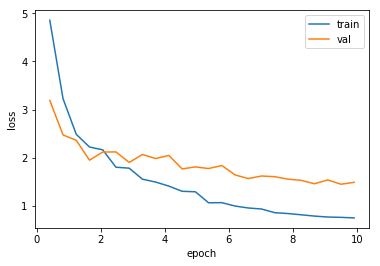

In [37]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train')
plt.plot(epochs, [x[2] for x in all_losses], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

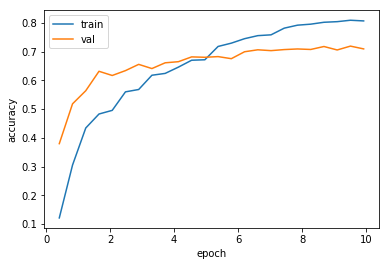

In [38]:
plt.plot(epochs, [x[3] for x in all_losses], label='train')
plt.plot(epochs, [x[4] for x in all_losses], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')


Text(0, 0.5, 'top5_accuracy')

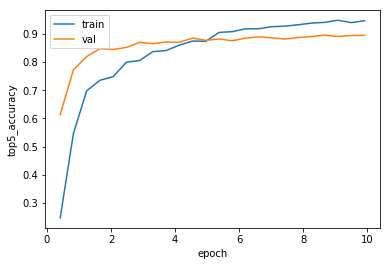

In [39]:
plt.plot(epochs, [x[5] for x in all_losses], label='train')
plt.plot(epochs, [x[6] for x in all_losses], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('top5_accuracy')

# Error analysis

### get human readable class names

In [40]:
# index to class name
decode = {val_folder.class_to_idx[k]: decode[int(k)] for k in val_folder.class_to_idx}


### get all predictions and all misclassified images 

In [41]:
val_iterator_no_shuffle = DataLoader(
    val_folder, batch_size=64, shuffle=False
)

In [43]:
val_predictions, val_true_targets,\
    erroneous_samples, erroneous_targets,\
    erroneous_predictions = predict(model, val_iterator_no_shuffle, return_erroneous=True)
# erroneous_samples: images that were misclassified
# erroneous_targets: their true labels
# erroneous_predictions: predictions for them

  0%|          | 0/81 [00:00<?, ?it/s]../training_utils\train_utils.py:164: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x_batch = Variable(x_batch.cuda(), volatile=True)
../training_utils\train_utils.py:165: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  y_batch = Variable(y_batch.cuda(), volatile=True)
../training_utils\train_utils.py:169: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)
100%|██████████| 81/81 [00:30<00:00,  2.61it/s]


### number of misclassified images (there are overall 5120 images in the val dataset)


In [44]:
n_errors = len(erroneous_targets)
n_errors

5140

### logloss and accuracies

In [45]:
log_loss(val_true_targets, val_predictions)

1.5174593192877321

In [46]:
accuracy_score(val_true_targets, val_predictions.argmax(1))

0.7130350194552529

In [47]:
print(top_k_accuracy(val_true_targets, val_predictions, k=(2, 3, 4, 5, 10)))

[0.8143968871595331, 0.8533073929961089, 0.8764591439688716, 0.8904669260700389, 0.9289883268482491]


### entropy of predictions

In [48]:
hits = val_predictions.argmax(1) == val_true_targets

c:\users\46029\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'entropy of predictions')

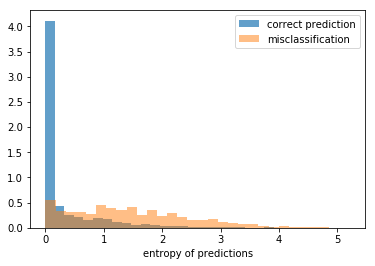

In [49]:
plt.hist(
    entropy(val_predictions[hits]), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
)
plt.hist(
    entropy(val_predictions[~hits]), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
)
plt.legend()
plt.xlabel('entropy of predictions')

### confidence of predictions

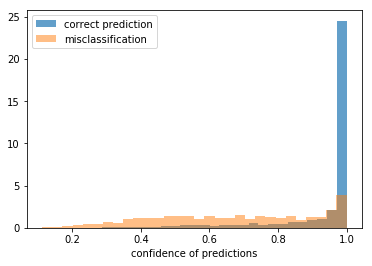

In [50]:
plt.hist(
    val_predictions[hits].max(1), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
)
plt.hist(
    val_predictions[~hits].max(1), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
)
plt.legend()
plt.xlabel('confidence of predictions');

### difference between biggest and second biggest probability

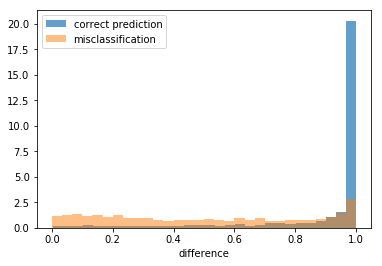

In [51]:
sorted_correct = np.sort(val_predictions[hits], 1)
sorted_incorrect = np.sort(val_predictions[~hits], 1)

plt.hist(
    sorted_correct[:, -1] - sorted_correct[:, -2], bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
)
plt.hist(
    sorted_incorrect[:, -1] - sorted_incorrect[:, -2], bins=30, 
    normed=True, alpha=0.5, label='misclassification'
)
plt.legend()
plt.xlabel('difference');

### probabilistic calibration of the model

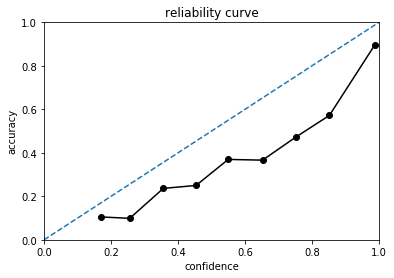

In [52]:
model_calibration(val_true_targets, val_predictions, n_bins=10)

### per class accuracies

Text(0.5, 0, 'accuracy')

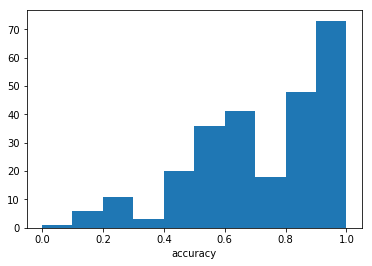

In [53]:
per_class_acc = per_class_accuracy(val_true_targets, val_predictions)
plt.hist(per_class_acc)
plt.xlabel('accuracy')

In [54]:
most_inaccurate_k_classes(per_class_acc, 15, decode)

clutter 0.0
waterfall 0.1
ladder 0.15
mailbox 0.15
frisbee 0.15
frog 0.15
saturn 0.15
spoon 0.2
skateboard 0.2
coffin 0.2
washing-machine 0.2
steering-wheel 0.25
fern 0.25
doorknob 0.25
knife 0.3


### class accuracy vs. number of samples in the class

Text(0.5, 0, 'number of available samples')

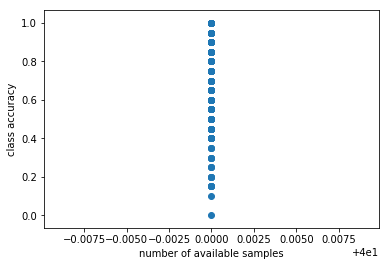

In [55]:
plt.scatter((1.0/w), per_class_acc)
plt.ylabel('class accuracy')
plt.xlabel('number of available samples')

### most confused pairs of classes

In [56]:
confused_pairs = most_confused_classes(
    val_true_targets, val_predictions, decode, min_n_confusions=4
)
confused_pairs

[('ak47', 'rifle'),
 ('beer-mug', 'coffee-mug'),
 ('hibiscus', 'iris'),
 ('horseshoe-crab', 'mussels'),
 ('iguana', 'triceratops'),
 ('iguana', 'fern'),
 ('jesus-christ', 'buddha'),
 ('joy-stick', 'saturn'),
 ('kayak', 'canoe'),
 ('ladder', 'tripod'),
 ('lathe', 'microscope'),
 ('light-house', 'windmill'),
 ('microscope', 'theodolite'),
 ('microwave', 'refrigerator'),
 ('microwave', 'washing-machine'),
 ('people', 'faces-easy'),
 ('boom-box', 'steering-wheel'),
 ('boom-box', 'washing-machine'),
 ('segway', 'car-tire'),
 ('sneaker', 'tennis-shoes'),
 ('speed-boat', 'canoe'),
 ('swan', 'duck'),
 ('breadmaker', 'toaster'),
 ('teapot', 'ewer'),
 ('top-hat', 'cowboy-hat'),
 ('tweezer', 'baseball-bat'),
 ('yo-yo', 'frisbee'),
 ('airplanes', 'fighter-jet'),
 ('greyhound', 'dog'),
 ('toad', 'frog'),
 ('backpack', 'baseball-glove'),
 ('chimp', 'gorilla'),
 ('chopsticks', 'baseball-bat'),
 ('baseball-bat', 'flashlight'),
 ('comet', 'galaxy'),
 ('duck', 'goose')]

### show some low entropy errors

In [57]:
erroneous_entropy = entropy(erroneous_predictions)
mean_entropy = erroneous_entropy.mean()
low_entropy = mean_entropy < erroneous_entropy
mean_entropy

0.6499661087177437

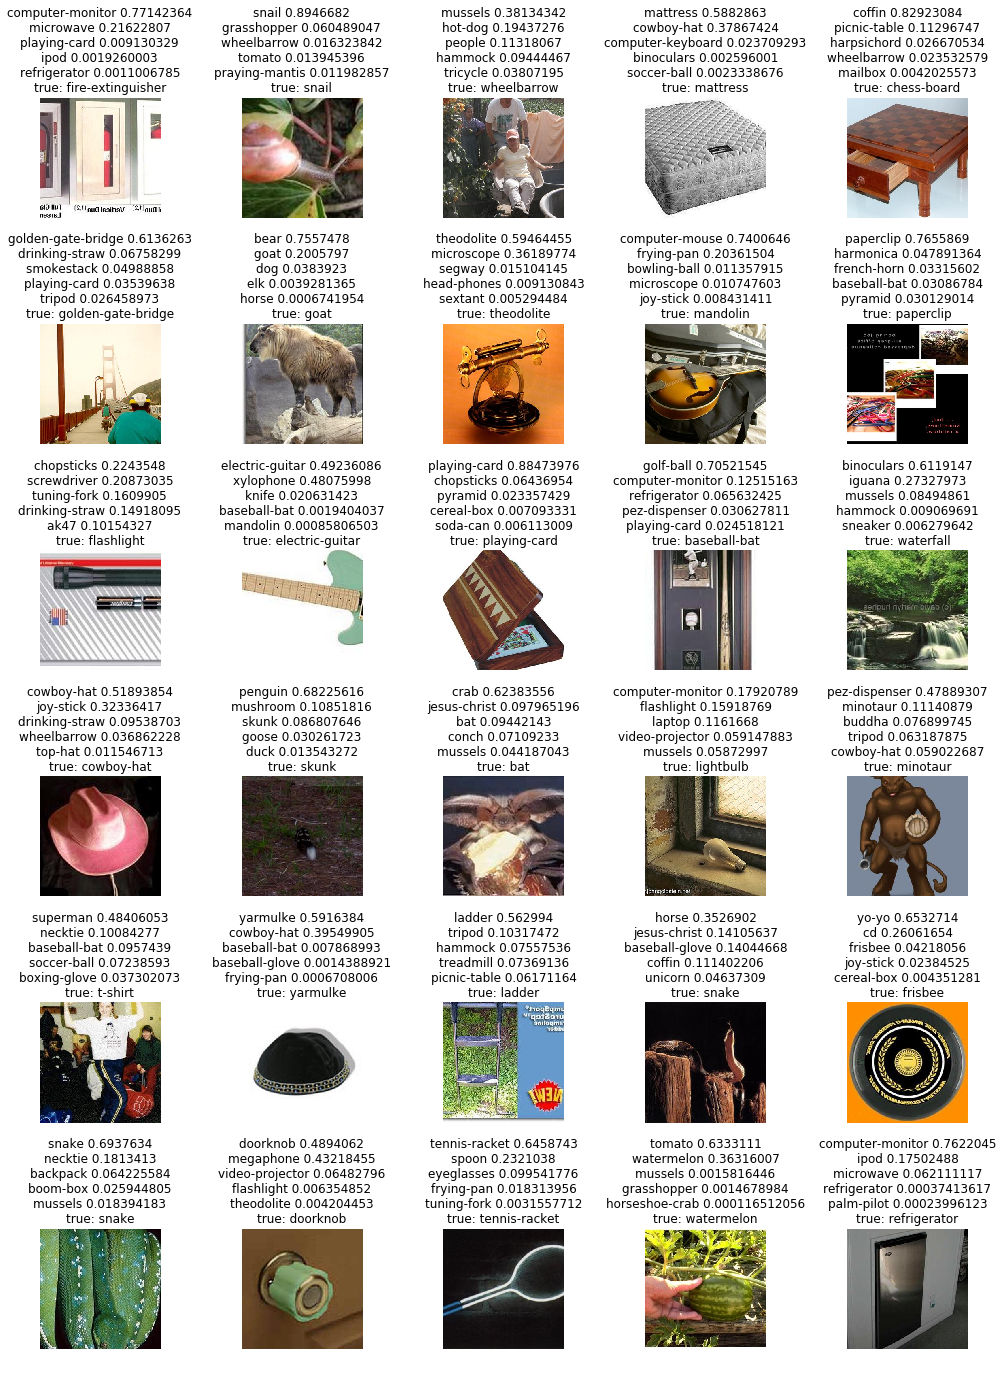

In [58]:
show_errors(
    erroneous_samples[low_entropy], 
    erroneous_predictions[low_entropy], 
    erroneous_targets[low_entropy], 
    decode
)

### show some high entropy errors

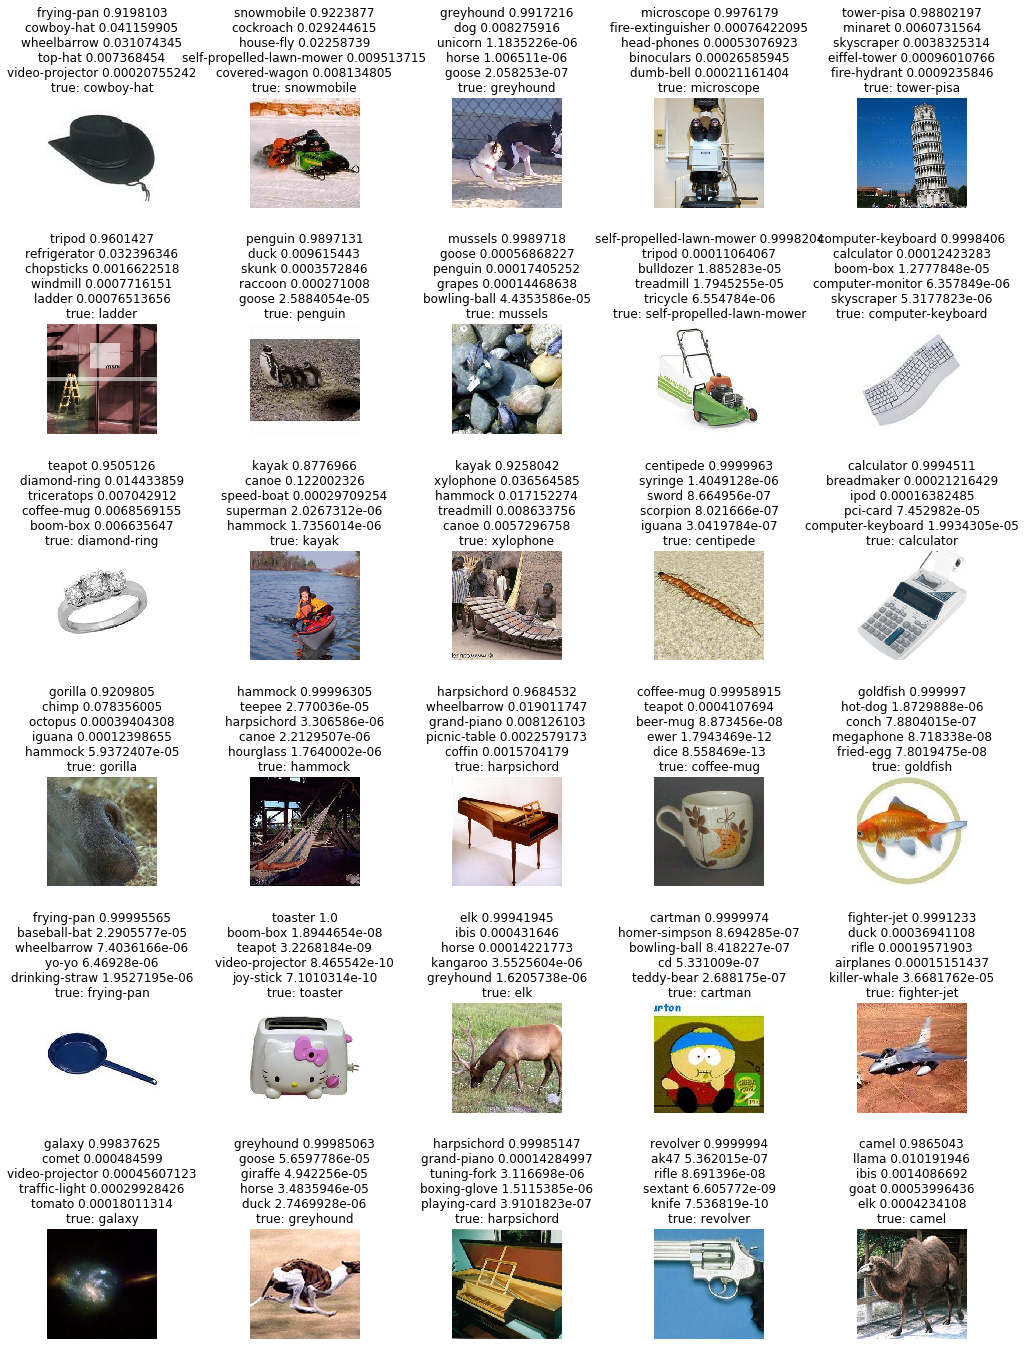

In [59]:
show_errors(
    erroneous_samples[~low_entropy], 
    erroneous_predictions[~low_entropy], 
    erroneous_targets[~low_entropy], 
    decode
)

# Save

In [60]:
model.cpu()
torch.save(model.state_dict(), 'model121.pytorch_state')
